<a href="https://colab.research.google.com/github/brigitayantie/random/blob/master/Earthquake_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img height="60px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="20px" vspace="5px">

<h1>Welcome to Colaboratory!</h1>
Colaboratory is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud. See our [FAQ](https://research.google.com/colaboratory/faq.html) for more info.

In [0]:
!pip install kaggle

!pip install numpy==1.15.0

!pip install catboost

    100% |████████████████████████████████| 13.9MB 2.8MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.2 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [0]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

In [0]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [0]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2527           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge       9894           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4090           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         35           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2380           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
LANL-Ear

In [0]:
!kaggle competitions download -c LANL-Earthquake-Prediction 

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 13.2MB/s]
 93% 224M/242M [00:01<00:00, 179MB/s]
100% 242M/242M [00:01<00:00, 174MB/s]
100% 2.02G/2.03G [00:39<00:00, 70.1MB/s]
100% 2.03G/2.03G [00:39<00:00, 55.5MB/s]


In [0]:
!unzip train.csv.zip
!ls

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               y
y
^C


In [0]:
!unzip train.csv.zip
!ls

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 'kaggle (1).json'  'kaggle (4).json'   sample_submission.csv   train.csv.zip
'kaggle (2).json'  'kaggle (5).json'   test.zip
'kaggle (3).json'   sample_data        train.csv


In [0]:
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [0]:
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


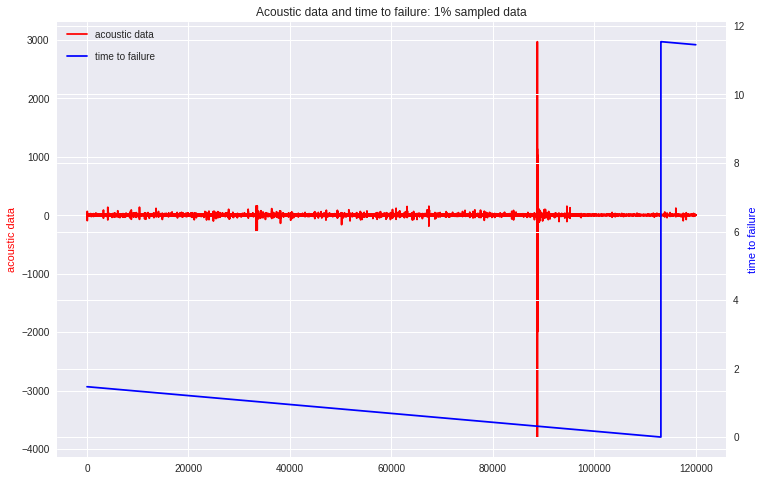

In [0]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [0]:
#better pred value, improve capabilities model
#stastical feature generate feature

def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)
  
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [0]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000
mean,4.671969,6.414090,-141.640094,155.316530,61.747699,0.112616,-10.923857,-2.028136,11.354045,20.334209,162.595545,5.648210,5.621489
std,0.246815,8.228879,246.119442,255.050535,58.417714,0.493745,13.147723,2.286243,2.370861,13.312407,283.457384,1.464059,8.068186
min,3.798020,2.981882,-4621.000000,33.000000,2.462750,-4.091826,-239.010000,-34.000000,9.000000,11.000000,33.000000,4.471280,2.719324
25%,4.494407,4.473646,-146.000000,92.000000,27.084491,-0.042238,-13.000000,-3.000000,10.000000,15.000000,93.000000,5.102987,3.853845
50%,4.667487,5.535037,-108.000000,121.000000,43.132084,0.079706,-10.000000,-2.000000,11.000000,19.000000,125.000000,5.504887,4.729958
75%,4.854480,6.748138,-79.000000,161.000000,71.328694,0.228853,-6.000000,-1.000000,12.000000,23.000000,166.000000,5.889000,5.777516
max,5.391993,142.976883,-24.000000,4610.000000,452.372653,3.135711,-2.000000,0.000000,42.000000,248.000000,4621.000000,28.832627,140.105751


In [0]:
#Model #1 - Catboost

train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 0.8636914148223283}}

In [0]:
!kaggle competitions download -c LANL-Earthquake-Prediction

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 11, in <module>
    load_entry_point('kaggle==1.5.2', 'console_scripts', 'kaggle')()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 489, in load_entry_point
    return get_distribution(dist).load_entry_point(group, name)
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2793, in load_entry_point
    return ep.load()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2411, in load
    return self.resolve()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2417, in resolve
    module = __import__(self.module_name, fromlist=['__name__'], level=0)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 116, in authenticate
    self.config_file, self.config_d

In [0]:
!kaggle competitions download -c LANL-Earthquake-Prediction

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 11, in <module>
    load_entry_point('kaggle==1.5.2', 'console_scripts', 'kaggle')()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 489, in load_entry_point
    return get_distribution(dist).load_entry_point(group, name)
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2793, in load_entry_point
    return ep.load()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2411, in load
    return self.resolve()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2417, in resolve
    module = __import__(self.module_name, fromlist=['__name__'], level=0)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 116, in authenticate
    self.config_file, self.config_d

## Getting Started
- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Loading and saving data: Local files, Drive, Sheets, Google Cloud Storage](/notebooks/io.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Using Google Cloud BigQuery](/notebooks/bigquery.ipynb)
- [Forms](/notebooks/forms.ipynb), [Charts](/notebooks/charts.ipynb), [Markdown](/notebooks/markdown_guide.ipynb), & [Widgets](/notebooks/widgets.ipynb)
- [TensorFlow with GPU](/notebooks/gpu.ipynb)
- [TensorFlow with TPU](/notebooks/tpu.ipynb)
- [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/): [Intro to Pandas](/notebooks/mlcc/intro_to_pandas.ipynb) & [First Steps with TensorFlow](/notebooks/mlcc/first_steps_with_tensor_flow.ipynb)
- [Using Colab with GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)


## Highlighted Features
### Seedbank

Looking for Colab notebooks to learn from? Check out [Seedbank](https://tools.google.com/seedbank/), a place to discover interactive machine learning examples.

### TensorFlow execution

Colaboratory allows you to execute TensorFlow code in your browser with a single click. The example below adds two matrices.

$\begin{bmatrix}
  1. & 1. & 1. \\
  1. & 1. & 1. \\
\end{bmatrix} +
\begin{bmatrix}
  1. & 2. & 3. \\
  4. & 5. & 6. \\
\end{bmatrix} =
\begin{bmatrix}
  2. & 3. & 4. \\
  5. & 6. & 7. \\
\end{bmatrix}$

In [0]:
import tensorflow as tf

input1 = tf.ones((2, 3))
input2 = tf.reshape(tf.range(1, 7, dtype=tf.float32), (2, 3))
output = input1 + input2

with tf.Session():
  result = output.eval()
result  

array([[2., 3., 4.],
       [5., 6., 7.]], dtype=float32)

### GitHub

For a full discussion of interactions between Colab and GitHub, see [Using Colab with GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb). As a brief summary:

To save a copy of your Colab notebook to Github, select *File → Save a copy to GitHub…*

To load a specific notebook from github, append the github path to http://colab.research.google.com/github/.
For example to load this notebook in Colab: [https://github.com/tensorflow/docs/blob/master/site/en/tutorials/_index.ipynb](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/_index.ipynb) use the following Colab URL: [https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/_index.ipynb](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/_index.ipynb)

To open a github notebook in one click, we recommend installing the [Open in Colab Chrome Extension](https://chrome.google.com/webstore/detail/open-in-colab/iogfkhleblhcpcekbiedikdehleodpjo).



### Visualization

Colaboratory includes widely used libraries like [matplotlib](https://matplotlib.org/), simplifying visualization.

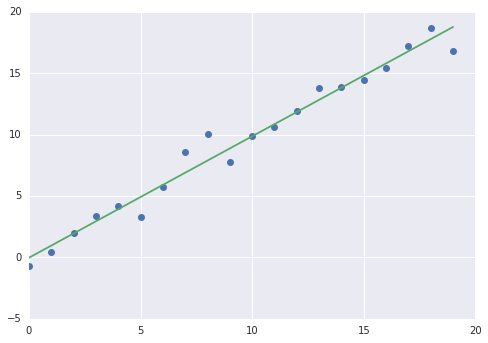

In [0]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(20)
y = [x_i + np.random.randn(1) for x_i in x]
a, b = np.polyfit(x, y, 1)
_ = plt.plot(x, y, 'o', np.arange(20), a*np.arange(20)+b, '-')

Want to use a new library?  `pip install` it at the top of the notebook. Then that library can be used anywhere else in the notebook. For recipes to import commonly used libraries, refer to the [importing libraries example notebook](/notebooks/snippets/importing_libraries.ipynb).

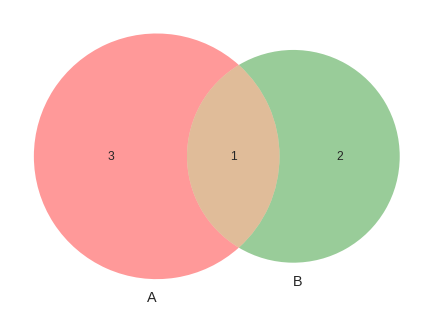

In [0]:
!pip install -q matplotlib-venn

from matplotlib_venn import venn2
_ = venn2(subsets = (3, 2, 1))

### Forms

Forms can be used to parameterize code. See the [forms example notebook](/notebooks/forms.ipynb) for more details.

In [0]:
#@title Examples

text = 'value' #@param 
date_input = '2018-03-22' #@param {type:"date"}
number_slider = 0 #@param {type:"slider", min:-1, max:1, step:0.1}
dropdown = '1st option' #@param ["1st option", "2nd option", "3rd option"]


### Local runtime support

Colab  supports connecting to a Jupyter runtime on your local machine. For more information, see our [documentation](https://research.google.com/colaboratory/local-runtimes.html).